<a href="https://colab.research.google.com/github/sahin-arslan/YapaySinirAglariFinal/blob/main/YapaySiniAgiFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## YAPAY SİNİR AĞI-FİNAL ÖDEVİ

## 1.	Gerekli Kütüphanelerin Yüklenmesi
*   pandas, numpy (veri işleme)
*   sklearn, TensorFlow/Keras (model oluşturma, veri ayırma, performans metrikleri)
*   matplotlib ve seaborn (görselleştirme)



In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import shutil
import cv2
from tqdm import tqdm
import kagglehub

##2.	Veri Seti Yükleme
    Face Mask Detection Dataset’i yükleyiniz.
https://www.kaggle.com/datasets/omkargurav/face-mask-dataset


In [3]:
# Dataset'i kaggledan cache'e alıyoruz
path = kagglehub.dataset_download("omkargurav/face-mask-dataset" ,force_download=True)

print("Path to dataset files:", path)

# Cachede bulunan datasetimizi content altına taşıyoruz
!mv {path}/data /content/dataset

100%|██████████| 163M/163M [00:08<00:00, 20.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1


In [4]:
# Veri setinin yolu
data_dir = "./dataset"
all_images = []
labels = []

# Klasörlerden tüm görüntüleri ve etiketleri alma
for category in ["with_mask", "without_mask"]:
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        all_images.append(os.path.join(category_path, img_name))
        labels.append(category)

# Veriyi %80 eğitim + validasyon, %20 test olarak ayırma
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    all_images, labels, test_size=0.2, stratify=labels, random_state=42)

# Eğitim ve validasyon verisini %80 eğitim, %20 validasyon olarak ayırma
train_images, valid_images, train_labels, valid_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.2, stratify=train_val_labels, random_state=42)

# Ayrılmış verileri yeni klasörlere kaydetme
split_data_dir = "./Face_Mask_Split_Dataset"
train_dir = os.path.join(split_data_dir, "Train")
valid_dir = os.path.join(split_data_dir, "Validation")
test_dir = os.path.join(split_data_dir, "Test")

for directory in [train_dir, valid_dir, test_dir]:
    os.makedirs(os.path.join(directory, "with_mask"), exist_ok=True)
    os.makedirs(os.path.join(directory, "without_mask"), exist_ok=True)

# Dosyaları ilgili klasörlere kopyalama
for img_path, label in zip(train_images, train_labels):
    shutil.copy(img_path, os.path.join(train_dir, label))
for img_path, label in zip(valid_images, valid_labels):
    shutil.copy(img_path, os.path.join(valid_dir, label))
for img_path, label in zip(test_images, test_labels):
    shutil.copy(img_path, os.path.join(test_dir, label))

## 3.	Önceden Eğitilmiş (Pre-trained) Modellerin Hazırlanması

Sınıflandırıcı olarak DenseNet121 ve MobileNetV1 (pre-trained) modellerinden en az biri kullanılacaktır. Base modeller indirildikten sonra 2 dense katmanı ve bir dropout katmanı ekleyiniz.



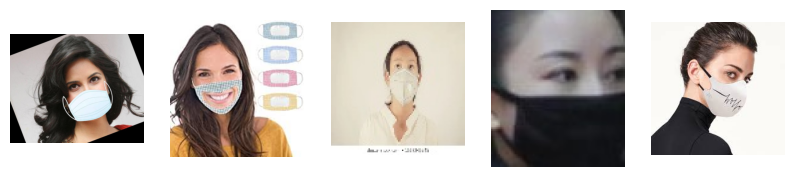

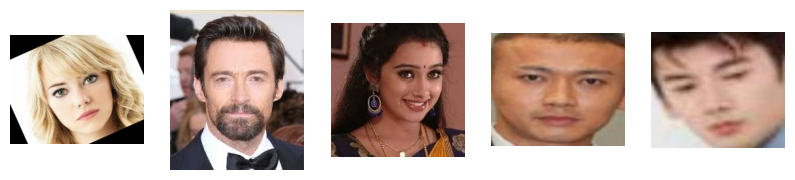

In [5]:
def show_sample_images(directory, category, num_images=5):
    path = os.path.join(directory, category)
    images = os.listdir(path)[:num_images]
    plt.figure(figsize=(10, 5))
    for i, img_name in enumerate(images):
        img = cv2.imread(os.path.join(path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

show_sample_images(train_dir, "with_mask")
show_sample_images(train_dir, "without_mask")

## 4.	Veri Setinin Eğitim/Validasyon ve Test Olarak Ayrılması:
Toplam verinin %20’si test set olarak ayrılmalı, %80’i eğitim/validasyon için bırakılmalıdır.

In [6]:
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4833 images belonging to 2 classes.
Found 1209 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


## 5.	Eğitim/Validasyon Setinin Bölünmesi ve Modelin Eğitilmesi
Daha önce ayırdığınız eğitim+validasyon verisini %80’i eğitim %20’si validasyon olarak rastgele bölün. Eğitim verisine  veri arttırımı uygulayın

In [7]:
#Memvuctta buluan DenseNet121 modeli üzerinden modelimizi oluşturuyoruz
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## 6. Modelin Derlenmesi

In [8]:
#Oluşturduğumuz modeli derliyoruz
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 7. Modelin Eğitilmesi

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
108/152 ━━━━━━━━━━━━━━━━━━━━ 14s 335ms/step - accuracy: 0.9962 - loss: 0.0129

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


152/152 ━━━━━━━━━━━━━━━━━━━━ 65s 427ms/step - accuracy: 0.9961 - loss: 0.0127 - val_accuracy: 0.9926 - val_loss: 0.0239 - learning_rate: 1.0000e-06
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 65s 426ms/step - accuracy: 0.9929 - loss: 0.0171 - val_accuracy: 0.9934 - val_loss: 0.0205 - learning_rate: 1.0000e-06
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 64s 422ms/step - accuracy: 0.9970 - loss: 0.0077 - val_accuracy: 0.9917 - val_loss: 0.0231 - learning_rate: 1.0000e-06
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 64s 424ms/step - accuracy: 0.9975 - loss: 0.0070 - val_accuracy: 0.9959 - val_loss: 0.0140 - learning_rate: 1.0000e-06
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 65s 425ms/step - accuracy: 0.9949 - loss: 0.0101 - val_accuracy: 0.9934 - val_loss: 0.0211 - learning_rate: 1.0000e-06
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 64s 423ms/step - accuracy: 0.9966 - loss: 0.0086 - val_accuracy: 0.9926 - val_loss: 0.0236 - learning_rate: 1.0000e-06
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 64s 424ms/s

## 8. Model Performansının Görselleştirilmesi

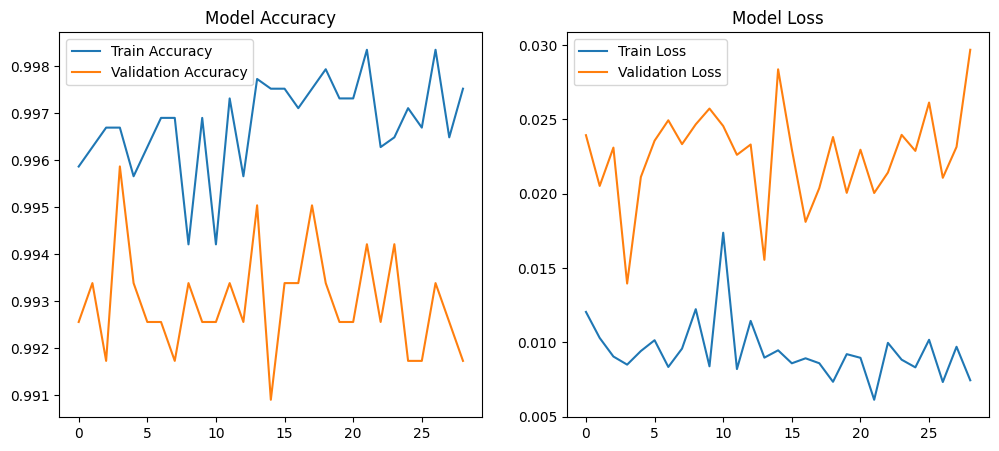

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

## 9. Test Verisi ile Tahmin ve Sonuç Analizi

48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 664ms/step


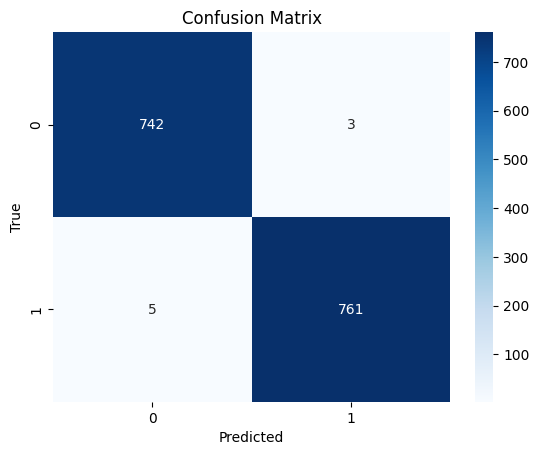

In [11]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 10. Performans Metrikleri

In [12]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       745
           1       1.00      0.99      0.99       766

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511

